In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

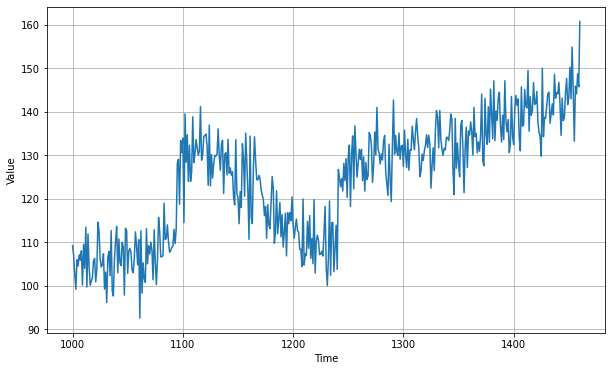

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)


Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 1881.6193
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 157.8761
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 125.0704
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 99.7532
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 88.0876
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 82.1075
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 76.6625
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 69.0702
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 65.8103
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 62.5715
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 60.4122
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 59.7894
Epoch 13/100
31/31 [=

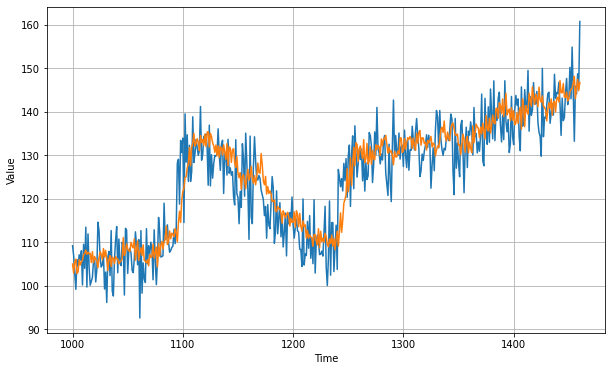

In [7]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.8431926

In [16]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 13709.6084
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 289.4328
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 106.5863
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 92.0332
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 91.2907
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 91.1107
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 90.8864
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 90.5466
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 90.0386
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 89.5904
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 89.0506
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 88.6917
Epoch 13/100
31/31 [

(1e-08, 0.001, 0.0, 300.0)

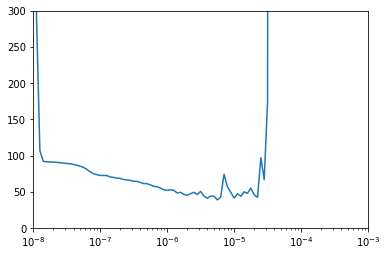

In [17]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [18]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=1)

84.8700
Epoch 263/500
31/31 [==============================] - 0s 2ms/step - loss: 982.2286
Epoch 264/500
31/31 [==============================] - 0s 2ms/step - loss: 979.6235
Epoch 265/500
31/31 [==============================] - 0s 2ms/step - loss: 977.0441
Epoch 266/500
31/31 [==============================] - 0s 2ms/step - loss: 974.4509
Epoch 267/500
31/31 [==============================] - 0s 2ms/step - loss: 971.9253
Epoch 268/500
31/31 [==============================] - 0s 2ms/step - loss: 969.3800
Epoch 269/500
31/31 [==============================] - 0s 2ms/step - loss: 966.9240
Epoch 270/500
31/31 [==============================] - 0s 2ms/step - loss: 964.4419
Epoch 271/500
31/31 [==============================] - 0s 2ms/step - loss: 962.0594
Epoch 272/500
31/31 [==============================] - 0s 2ms/step - loss: 959.6202
Epoch 273/500
31/31 [==============================] - 0s 2ms/step - loss: 957.2394
Epoch 274/500
31/31 [==============================] - 0s 2ms/step -

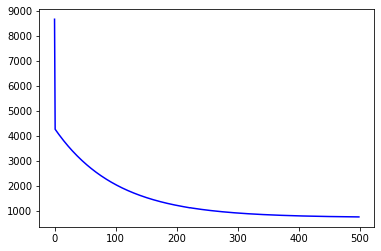

In [19]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[3949.86376953125, 3917.69970703125, 3885.990478515625, 3854.672607421875, 3823.49658203125, 3792.8408203125, 3762.28076171875, 3732.125732421875, 3702.3359375, 3672.697998046875, 3643.48828125, 3614.472900390625, 3585.93359375, 3557.462646484375, 3529.37158203125, 3501.633056640625, 3474.282958984375, 3446.92333984375, 3419.995361328125, 3393.34814453125, 3367.047607421875, 3340.80908203125, 3314.910400390625, 3289.284423828125, 3264.006103515625, 3238.8779296875, 3213.928955078125, 3189.146484375, 3164.823974609375, 3140.6845703125, 3116.65478515625, 3092.888427734375, 3069.4755859375, 3046.25341796875, 3023.303466796875, 3000.577880859375, 2978.05908203125, 2955.616943359375, 2933.60986328125, 2911.67138671875, 2889.869140625, 2868.248779296875, 2847.07958984375, 2825.829345703125, 2804.90478515625, 2784.2763671875, 2763.760009765625, 2743.577880859375, 2723.615966796875, 2703.717529296875, 2684.2158203125, 2664.682373046875, 2645.437744140625, 2626.352783203125, 2607.412841796875, 

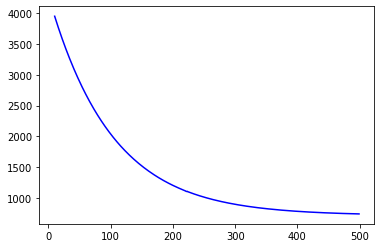

In [20]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

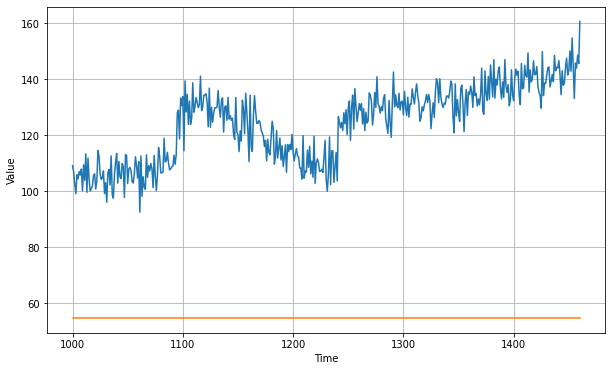

In [21]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

69.63741